# Analyze Intrinsice frequency using the Method proposed by Mizuseki et al. 2009, by analyzing spike phase spectrum, which is immune to the frequency changes of LFP theta

In [1]:
import os
import shutil
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve1d
from numpy import deg2rad
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
from scipy.signal import welch
from mne.time_frequency import psd_array_multitaper
import seaborn as sns
from scipy.ndimage import gaussian_filter1d, center_of_mass
from scipy.signal import hilbert


import HD_utils

%matplotlib inline
%load_ext autoreload
%autoreload 2


## Section 1: define functions

In [2]:
def load_data(ratname, file_path):
    # Load the .mat file
    with h5py.File(file_path, 'r') as f:
        # Access the sdata structure
        sdata = f['sdata']

        # Check if 'light1' exists in sdata
        if 'light1' not in sdata:
            print(f"'light1' not found in {file_path}")
            return None

        # Accessing the light1 group and its datasets
        theta = np.array(sdata['theta']).flatten()
        thetatimes = np.array(sdata['thetatimes']).flatten()
        eeg = np.array(sdata['eeg']).flatten()
        light1 = sdata['light1']
        ppox = np.array(light1['pox'])
        ppoy = np.array(light1['poy'])
        pot = np.array(light1['pot'])
        poh = np.array(light1['poh'])
        pov = np.array(light1['pov'])
        f0 = np.array(light1['F0'])
        sintcptFreqy = np.array(light1['sintcptFreqy'])

        # Extract all cells containing the name 'R222'
        cell_names = [key for key in sdata.keys() if ratname in key]
        #print(f"Cell Names: {cell_names}")

        # Initialize dictionary to store data for all cells
        cells_data = {}

        # Iterate over each cell name and extract data
        for cell_name in cell_names:
            part_now = 'light1'  # Assuming 'light1' is the part_now equivalent

            pspx = np.array(sdata[cell_name][part_now]['spx'])
            pspy = np.array(sdata[cell_name][part_now]['spy'])
            pspt = np.array(sdata[cell_name][part_now]['spt'])
            pspv = np.array(sdata[cell_name][part_now]['spv'])
            psph = np.array(sdata[cell_name][part_now]['sph'])
            pspm = np.array(sdata[cell_name][part_now]['spm'])
            pval = np.array(sdata[cell_name][part_now]['pval'])
            spike_phase = np.array(sdata[cell_name][part_now]['spike_phase'])
            autocorrelogram = np.array(sdata[cell_name][part_now]['theta_train_long2'])
            hd_mean = np.array(sdata[cell_name][part_now]['hd_mean'])
            hd_std = np.array(sdata[cell_name][part_now]['hd_stdev'])
            tune_width = np.array(sdata[cell_name][part_now]['tuning_width'])
            intrinsic_freq = np.array(sdata[cell_name][part_now]['intrinsic_theta_frequency'])

            # Extract and decode cell_type
            cell_type_array = np.array(sdata[cell_name][part_now]['thetacell_type'])
            cell_type = ''.join([chr(ascii_val[0]) for ascii_val in cell_type_array])

            # Store the data for this cell
            cells_data[cell_name] = {
                'pspx': pspx,
                'pspy': pspy,
                'pspt': pspt,
                'pspv': pspv,
                'psph': psph,
                'pspm': pspm,
                'pval': pval,
                'spike_phase': spike_phase,
                'autocorrelogram': autocorrelogram,
                'hd_mean': hd_mean,
                'hd_std': hd_std,
                'tune_width': tune_width,
                'intrinsic_freq': intrinsic_freq,
                'cell_type': cell_type
            }

        # Create a dictionary to store all the data
        data_dict = {
            'ppox': ppox,
            'ppoy': ppoy,
            'pot': pot,
            'poh': poh,
            'pov': pov,
            'f0': f0,
            'sintcptFreqy': sintcptFreqy,
            'cell_names': cell_names,
            'cells_data': cells_data,
            'theta': theta,
            'thetatimes': thetatimes,
            'eeg': eeg
        }

        return data_dict

def get_unwrap_phase(filtered_lfp):
    """
    get the instantaneous unwrap phase of the filtered lfp signal
    """
    
    analytic_signal = hilbert(filtered_lfp)
    instantaneous_unwrap_phase = np.unwrap(np.angle(analytic_signal))+np.pi 
    
    return instantaneous_unwrap_phase

## Section 2: get intrinsic frequency of an example neuron

In [3]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'

total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = load_data(ratname, file_path)
                
                if data_dict is not None:
                    theta_times = data_dict['thetatimes']
                    lfp_theta = data_dict['theta']                
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        matnames[cell_name] = [ratname, file_path]

Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
'light1' not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_030919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_230819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_200819_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhas

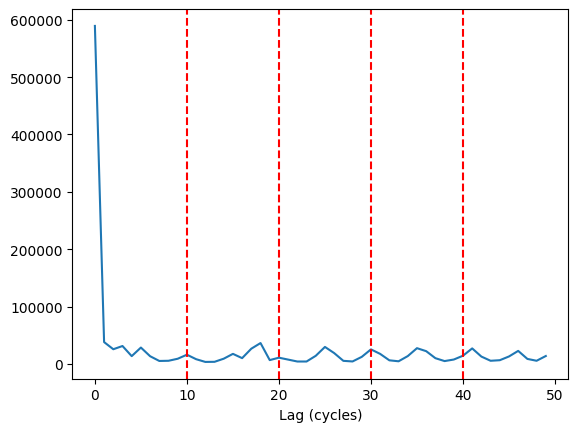

In [9]:
cell_name = 'rR762_01022019_t2_c1' 
# cell_name = 'rR651_26062019_t1_c1'
# cell_name = 'rR222_12032019_t4_c3'
# cell_name = 'rR222_15032019_t4_c1'
# cell_name = 'rR449_23032020_t1_c3'
cell_name = 'rR448_25032020_t4_c1'
cell_name = 'rR449_23032020_t1_c3'
# cell_name = 'rR448_14032020_t4_c1'
ratname, file_path = matnames[cell_name]
data_dict = load_data(ratname, file_path)

rotation_only = False

#calculate the power spectrum of a spike train for a cell using direct multi-taper method
cell_name = data_dict['cell_names'][0]

theta_times = data_dict['thetatimes']

lfp_theta = data_dict['theta']
unwrap_phase = get_unwrap_phase(lfp_theta) #this unsrap phase is monotonic increasing, rather than cyclic
unwrap_phase = unwrap_phase/(2*np.pi) #normalize by 2pi

spiketimes = data_dict['cells_data'][cell_name]['pspt'].flatten() #spike time
if rotation_only is True:  #further filter the spike train by rotation periods
    # Configuration
    config = {
        'hd_bins': 60,
        'hd_boxcar': 3,
        'speed_threshold': 0.5,
        'duration_threshold': 0.5,
        'speed_smooth_sigma': 2, 
        'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
        'interpolation_factor': 2 #1 is 0.02s, and 2 is 0.01s
    }
    poh = data_dict['poh'].flatten()
    pot = data_dict['pot'].flatten()
    spiketimes = HD_utils.get_rotation_spiketimes(poh, pot, spiketimes, config)
    
#assign unwrap_phase to each spike using interpolation
unwrap_spike_phase = np.interp(spiketimes, theta_times, unwrap_phase)

#generate a equal space array from 0 to np.ceil(unwrap_phase[-1]) with space 0.02
bins=10
relative = np.arange(0, np.ceil(unwrap_phase[-1]), 1/bins)

phasearray = HD_utils.compute_spike_array(unwrap_spike_phase, relative)

#perform auto correlation on unwrap_spike_phase on 250*5 time points intotal 1250 points
autocorrelogram = np.correlate(phasearray, phasearray, mode='full')

autocorrelogram = autocorrelogram[autocorrelogram.size//2:autocorrelogram.size//2+5*bins] #5 cycles

#

plt.figure()
plt.plot(autocorrelogram)
#add vertical line at 50, 100, 150, 200
plt.axvline(x=bins, color='r', linestyle='--')
plt.axvline(x=2*bins, color='r', linestyle='--')
plt.axvline(x=3*bins, color='r', linestyle='--')
plt.axvline(x=4*bins, color='r', linestyle='--')
plt.xlabel('Lag (cycles)')
plt.show()

# the following two are the same exact thing!!!
# phasearray = HD_utils.compute_spike_array(unwrap_spike_phase, unwrap_phase)
# spikearray = HD_utils.compute_spike_array(spiketimes, data_dict['thetatimes'])

#aclculate the power spectrum of the spike train using direct multi-taper method
